In [1]:
import spacy
from spacy import displacy

import en_core_sci_md
import en_core_sci_lg
import en_ner_craft_md
import en_ner_jnlpba_md
import en_ner_bc5cdr_md


import scispacy
import en_ner_bc5cdr_md

import pandas as pd
pd.options.mode.chained_assignment = None
import numpy as np
import re

from gensim.models import word2vec

from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
%matplotlib inline



## Load DIAGNOSES_ICD and NOTEEVENTS data from locally stored csv files

In [2]:
# Load the CSV files into DataFrames
diagnoses_df = pd.read_csv('/Users/balajisethuraman/Mother/UT-Austin/msai/sp25/ai_in_healthcare/mimic_nlp/AIinHealthNLP/DIAGNOSES_ICD.csv')
noteevents_df = pd.read_csv('/Users/balajisethuraman/Mother/UT-Austin/msai/sp25/ai_in_healthcare/mimic_nlp/AIinHealthNLP/NOTEEVENTS.csv')

/var/folders/53/t0lk0nc97355b8lqtgt3n97h0000gn/T/ipykernel_91042/447924319.py:3: DtypeWarning: Columns (4,5) have mixed types. Specify dtype option on import or set low_memory=False.
  noteevents_df = pd.read_csv('/Users/balajisethuraman/Mother/UT-Austin/msai/sp25/ai_in_healthcare/mimic_nlp/AIinHealthNLP/NOTEEVENTS.csv')


In [3]:
# Copy the base DataFrames to new DataFrames

diagnoses_df_1 = diagnoses_df
noteevents_df_1 = noteevents_df

In [4]:
# Filter the DIAGNOSES_ICD DataFrame based on the specified ICD9_CODE values
# ICD codes refers to Hypertension NOS, Crnry athrscl natve vssl, Atrial fibrillation, CHF NOS, Acute kidney failure NOS

filtered_diagnoses_df = diagnoses_df_1[diagnoses_df_1['ICD9_CODE'].isin(['4019', '42731', '4280', '41401', '5849'])]


print(filtered_diagnoses_df.iloc[0])
print(filtered_diagnoses_df.columns)

print(len(filtered_diagnoses_df))

ROW_ID          1491
SUBJECT_ID       112
HADM_ID       174105
SEQ_NUM          4.0
ICD9_CODE      41401
Name: 31, dtype: object
Index(['ROW_ID', 'SUBJECT_ID', 'HADM_ID', 'SEQ_NUM', 'ICD9_CODE'], dtype='object')
68253


In [5]:
# Filter the NOTEEVENTS DataFrame based on the CATEGORY 'Echo'
filtered_noteevents_df = noteevents_df_1[noteevents_df_1['CATEGORY'] == 'Echo']

print(filtered_noteevents_df.iloc[0])
print(filtered_noteevents_df.columns)

print(len(filtered_noteevents_df))

ROW_ID                                                     59653
SUBJECT_ID                                                 31038
HADM_ID                                                 174978.0
CHARTDATE                                             2102-06-14
CHARTTIME                                                    NaN
STORETIME                                                    NaN
CATEGORY                                                    Echo
DESCRIPTION                                               Report
CGID                                                         NaN
ISERROR                                                      NaN
TEXT           PATIENT/TEST INFORMATION:\nIndication: Endocar...
Name: 52108, dtype: object
Index(['ROW_ID', 'SUBJECT_ID', 'HADM_ID', 'CHARTDATE', 'CHARTTIME',
       'STORETIME', 'CATEGORY', 'DESCRIPTION', 'CGID', 'ISERROR', 'TEXT'],
      dtype='object')
45794


In [6]:
# Perform the join on the 'SUBJECT_ID' column
result_df = pd.merge(
    filtered_diagnoses_df,
    filtered_noteevents_df,
    on='SUBJECT_ID',
    how='inner'
)

In [7]:
# Display the resulting DataFrame
print(result_df)

print(result_df.iloc[0])
print(result_df.columns)

print(len(result_df))

        ROW_ID_x  SUBJECT_ID  HADM_ID_x  SEQ_NUM ICD9_CODE  ROW_ID_y  \
0           1491         112     174105      4.0     41401    104699   
1           1511         115     114585     10.0      4280     82745   
2           1513         115     114585     12.0      4019     82745   
3           1527         117     140784      5.0      4280     75070   
4           1527         117     140784      5.0      4280     75154   
...          ...         ...        ...      ...       ...       ...   
146257    639751       97488     152542      7.0      4280     91295   
146258    639767       97488     161999     12.0     42731     91295   
146259    639768       97488     161999     13.0      4019     91295   
146260    639772       97488     161999     17.0      4280     91295   
146261    639794       97497     168949      7.0     42731     68874   

        HADM_ID_y   CHARTDATE CHARTTIME STORETIME CATEGORY DESCRIPTION  CGID  \
0             NaN  2195-10-16       NaN       NaN     E

In [8]:
# Select only the required columns
result_df_ref = result_df[['SUBJECT_ID', 'CATEGORY', 'TEXT', 'ICD9_CODE']]

# Display the resulting refined DataFrame
print(result_df_ref)

        SUBJECT_ID CATEGORY  \
0              112     Echo   
1              115     Echo   
2              115     Echo   
3              117     Echo   
4              117     Echo   
...            ...      ...   
146257       97488     Echo   
146258       97488     Echo   
146259       97488     Echo   
146260       97488     Echo   
146261       97497     Echo   

                                                     TEXT ICD9_CODE  
0       PATIENT/TEST INFORMATION:\nIndication: Syncope...     41401  
1       PATIENT/TEST INFORMATION:\nIndication: Left ve...      4280  
2       PATIENT/TEST INFORMATION:\nIndication: Left ve...      4019  
3       PATIENT/TEST INFORMATION:\nIndication: Murmur....      4280  
4       PATIENT/TEST INFORMATION:\nIndication: Left ve...      4280  
...                                                   ...       ...  
146257  PATIENT/TEST INFORMATION:\nIndication: Stroke ...      4280  
146258  PATIENT/TEST INFORMATION:\nIndication: Stroke ...     42731

In [9]:
# to keep only certain (say for eg. 10) number of rows of a dataframe
print(result_df_ref[:10]) # this will fetch the top 10 rows

result_df_ref[-10:] # this will fetch the last 10 rows

   SUBJECT_ID CATEGORY                                               TEXT  \
0         112     Echo  PATIENT/TEST INFORMATION:\nIndication: Syncope...   
1         115     Echo  PATIENT/TEST INFORMATION:\nIndication: Left ve...   
2         115     Echo  PATIENT/TEST INFORMATION:\nIndication: Left ve...   
3         117     Echo  PATIENT/TEST INFORMATION:\nIndication: Murmur....   
4         117     Echo  PATIENT/TEST INFORMATION:\nIndication: Left ve...   
5         117     Echo  PATIENT/TEST INFORMATION:\nIndication: Murmur....   
6         117     Echo  PATIENT/TEST INFORMATION:\nIndication: Left ve...   
7         117     Echo  PATIENT/TEST INFORMATION:\nIndication: Murmur....   
8         117     Echo  PATIENT/TEST INFORMATION:\nIndication: Left ve...   
9         117     Echo  PATIENT/TEST INFORMATION:\nIndication: Murmur....   

  ICD9_CODE  
0     41401  
1      4280  
2      4019  
3      4280  
4      4280  
5      4019  
6      4019  
7      5849  
8      5849  
9      4019 

,SUBJECT_ID,CATEGORY,TEXT,ICD9_CODE
146252,97164,Echo,PATIENT/TEST INFORMATION:\nIndication: Endocar...,4019
146253,97172,Echo,PATIENT/TEST INFORMATION:\nIndication: Hyperte...,5849
146254,97172,Echo,PATIENT/TEST INFORMATION:\nIndication: Hyperte...,4280
146255,97488,Echo,PATIENT/TEST INFORMATION:\nIndication: Stroke ...,42731
146256,97488,Echo,PATIENT/TEST INFORMATION:\nIndication: Stroke ...,4019
146257,97488,Echo,PATIENT/TEST INFORMATION:\nIndication: Stroke ...,4280
146258,97488,Echo,PATIENT/TEST INFORMATION:\nIndication: Stroke ...,42731
146259,97488,Echo,PATIENT/TEST INFORMATION:\nIndication: Stroke ...,4019
146260,97488,Echo,PATIENT/TEST INFORMATION:\nIndication: Stroke ...,4280
146261,97497,Echo,PATIENT/TEST INFORMATION:\nIndication: Left ve...,42731


## Using Spacy NER
## Extract Entity

In [10]:
nlp = spacy.load('en_core_web_sm')

for index, text in enumerate(result_df_ref['TEXT']):
    if index >= 100:  # Stop after 100 iterations
        break
    #print(f"Index: {index}, Text: {text}")
    # visualize entities using displacy
    # Name Entities
    doc1 = nlp(text)
    displacy.render(doc1, style="ent", jupyter=True)    

## Scispacy NER
## Extract Entity 

In [11]:
nlp = en_ner_bc5cdr_md.load()

for index, text in enumerate(result_df_ref['TEXT']):
    if index >= 100:  # Stop after 100 iterations
        break
    #print(f"Index: {index}, Text: {text}")
    # visualize entities using displacy
    # Name Entities
    doc1 = nlp(text)
    displacy.render(doc1, style="ent", jupyter=True)    


/Users/balajisethuraman/Mother/UT-Austin/msai/venv_3.11.9/lib/python3.11/site-packages/spacy/language.py:2195: FutureWarning: Possible set union at position 6328
  deserializers["tokenizer"] = lambda p: self.tokenizer.from_disk(  # type: ignore[union-attr]


## Using Word2Vec Encoding

In [12]:
df=result_df_ref
#nlp = spacy.load('en_core_web_sm')
nlp = spacy.load('en_ner_bc5cdr_md')


In [13]:
# Fetch only the 'TEXT' column from the DataFrame
text_column = df['TEXT']

# Build corpus of all the entities extracted from the notes using spaCy model.
# The corpus is an array of arrays or list of lists where each of the nested lists corresponds to a note.
corpus = []
for index, text in enumerate(df['TEXT']):  # Iterate over the 'TEXT' column
    if index >= 1000:  # Stop after 100 iterations
        break
    str_tokens = []
    tokens = nlp(text).ents  # Process each text using spaCy
    for token in tokens:
        str_tokens.append(token.text)  # Extract entity text
    corpus.append(str_tokens)  # Add to the corpus

In [14]:
from gensim.models import Word2Vec
model1 = Word2Vec(corpus, min_count=40, window=10, workers=4, vector_size=100)

In [15]:
model1.wv.key_to_index.keys()

dict_keys(['pericardial effusion', 'Date/Time', 'mitral regurgitation', 'depressed', 'LA', 'aortic regurgitation', 'hypertension', 'akinetic', 'MR', 'pulmonary artery systolic hypertension', 'aortic valve stenosis', 'calcification', 'ventricular hypertrophy', 'atheroma', 'left ventricular systolic function', 'mitral\nregurgitation', 'tricuspid regurgitation', 'calcifications', 'mitral valve prolapse', 'atrial septal defect', 'AHA endocarditis', 'aortic stenosis', 'mitral valve chordae', 'pulmonary artery systolic', 'thrombus', 'pulmonary artery systolic pressure', 'Coronary artery disease', 'mitral annular calcification', 'hypertrophy', 'tamponade', 'Endocarditis', 'left ventricular systolic dysfunction', 'Congestive heart failure', 'valvular regurgitation', 'Mildly dilated RA', 'effusion', 'thrombi', 'pulmonic regurgitation', 'ventricular septal defect', 'systolic dysfunction', 'endocarditis', 'Trace aortic regurgitation', 'loculated anterior pericardial effusion', 'coarctation', 'Mil

## Use the model to look at similar words to “mitral regurgitation”

In [16]:
model1.wv.similar_by_word('mitral regurgitation')

[('AHA endocarditis', 0.9989473223686218),
 ('thrombi', 0.9988417625427246),
 ('pulmonic regurgitation', 0.9987707734107971),
 ('hypertension', 0.9987611174583435),
 ('mitral annular calcification', 0.9986889958381653),
 ('LA', 0.9986882209777832),
 ('hypertrophy', 0.9986851215362549),
 ('aortic valve leaflets', 0.9986746311187744),
 ('Coronary artery disease', 0.9986677169799805),
 ('ventricular hypertrophy', 0.9986245036125183)]

In [17]:
model1.wv.similarity('mitral regurgitation', 'aortic stenosis')

0.9983704

In [18]:
model1.wv.similarity('hypertension', 'aortic stenosis')

0.9984779

In [19]:
def tsne_plot(model,words, preTrained=False):
    "Creates and TSNE model and plots it"
    labels = []
    tokens = []

    for word in words:
      if preTrained:
          tokens.append(model[word])
      else:
          tokens.append(model.wv[word])
      labels.append(word)

    tokens = np.array(tokens)
    tsne_model = TSNE(perplexity=30, early_exaggeration=12, n_components=2, init='pca', n_iter=1000, random_state=23)
    new_values = tsne_model.fit_transform(tokens)

    x = []
    y = []
    for value in new_values:
        x.append(value[0])
        y.append(value[1])

    plt.figure(figsize=(16, 16))
    for i in range(len(x)):
        plt.scatter(x[i],y[i])
        plt.annotate(labels[i],
                     xy=(x[i], y[i]),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
    plt.title("t-SNE Visualization of Word Embeddings")
    plt.show()

/Users/balajisethuraman/Mother/UT-Austin/msai/venv_3.11.9/lib/python3.11/site-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


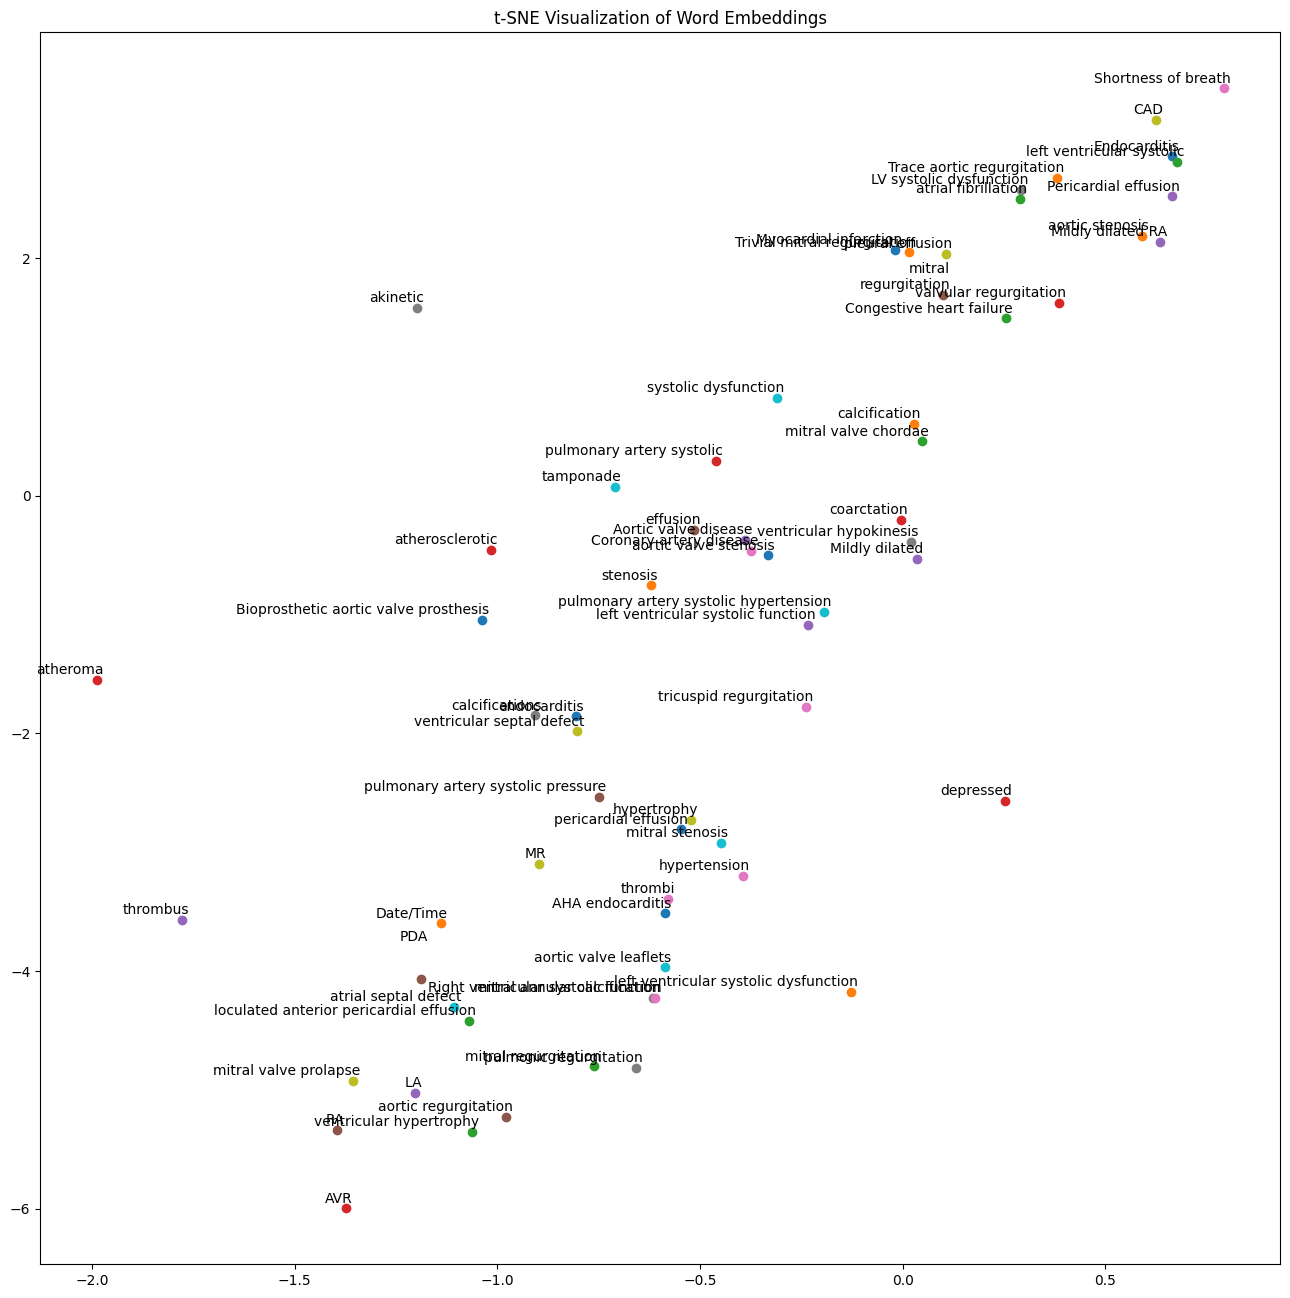

In [20]:
vocabs = model1.wv.key_to_index.keys()
new_v = np.array(list(vocabs))
tsne_plot(model1,new_v)

In [21]:
# load pre-trained word2vec embeddings
import gensim
import gensim.downloader as api

info = api.info()  # show info about available models/datasets
pretrained_model= api.load("glove-wiki-gigaword-50")  # download the model and return as object ready for use

In [22]:
new_corpus_in_pretrained_model = []
for word in new_v:
    if word in pretrained_model.key_to_index:
        new_corpus_in_pretrained_model.append(word)
    else:
        print(word)  # Print out-of-vocabulary words

pericardial effusion
Date/Time
mitral regurgitation
LA
aortic regurgitation
akinetic
MR
pulmonary artery systolic hypertension
aortic valve stenosis
ventricular hypertrophy
left ventricular systolic function
mitral
regurgitation
tricuspid regurgitation
mitral valve prolapse
atrial septal defect
AHA endocarditis
aortic stenosis
mitral valve chordae
pulmonary artery systolic
pulmonary artery systolic pressure
Coronary artery disease
mitral annular calcification
Endocarditis
left ventricular systolic dysfunction
Congestive heart failure
valvular regurgitation
Mildly dilated RA
pulmonic regurgitation
ventricular septal defect
systolic dysfunction
Trace aortic regurgitation
loculated anterior pericardial effusion
Mildly dilated
PDA


Right ventricular systolic function
LV systolic dysfunction
pleural effusion
mitral stenosis
Myocardial infarction
left ventricular systolic
AVR
Aortic valve disease
RA
Shortness of breath
ventricular hypokinesis
CAD
aortic valve leaflets
Bioprosthetic aortic v

In [23]:
import numpy as np

def tsne_plot(model, words):
    "Creates a t-SNE model and plots it"
    labels = []
    tokens = []

    for word in words:
        if word in model:
            tokens.append(model[word])
            labels.append(word)
        else:
            print(f"Skipping '{word}' as it is not present in the model's vocabulary.")

    tsne_model = TSNE(perplexity=11, early_exaggeration=12, n_components=2, init='pca', n_iter=1000, random_state=23)
    new_values = tsne_model.fit_transform(np.array(tokens))  # Convert tokens to a NumPy array

    x = []
    y = []
    for value in new_values:
        x.append(value[0])
        y.append(value[1])

    plt.figure(figsize=(16, 16))
    for i in range(len(x)):
        plt.scatter(x[i], y[i])
        plt.annotate(labels[i],
                     xy=(x[i], y[i]),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
    plt.title("t-SNE Visualization of Word Embeddings")
    plt.show()

/Users/balajisethuraman/Mother/UT-Austin/msai/venv_3.11.9/lib/python3.11/site-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


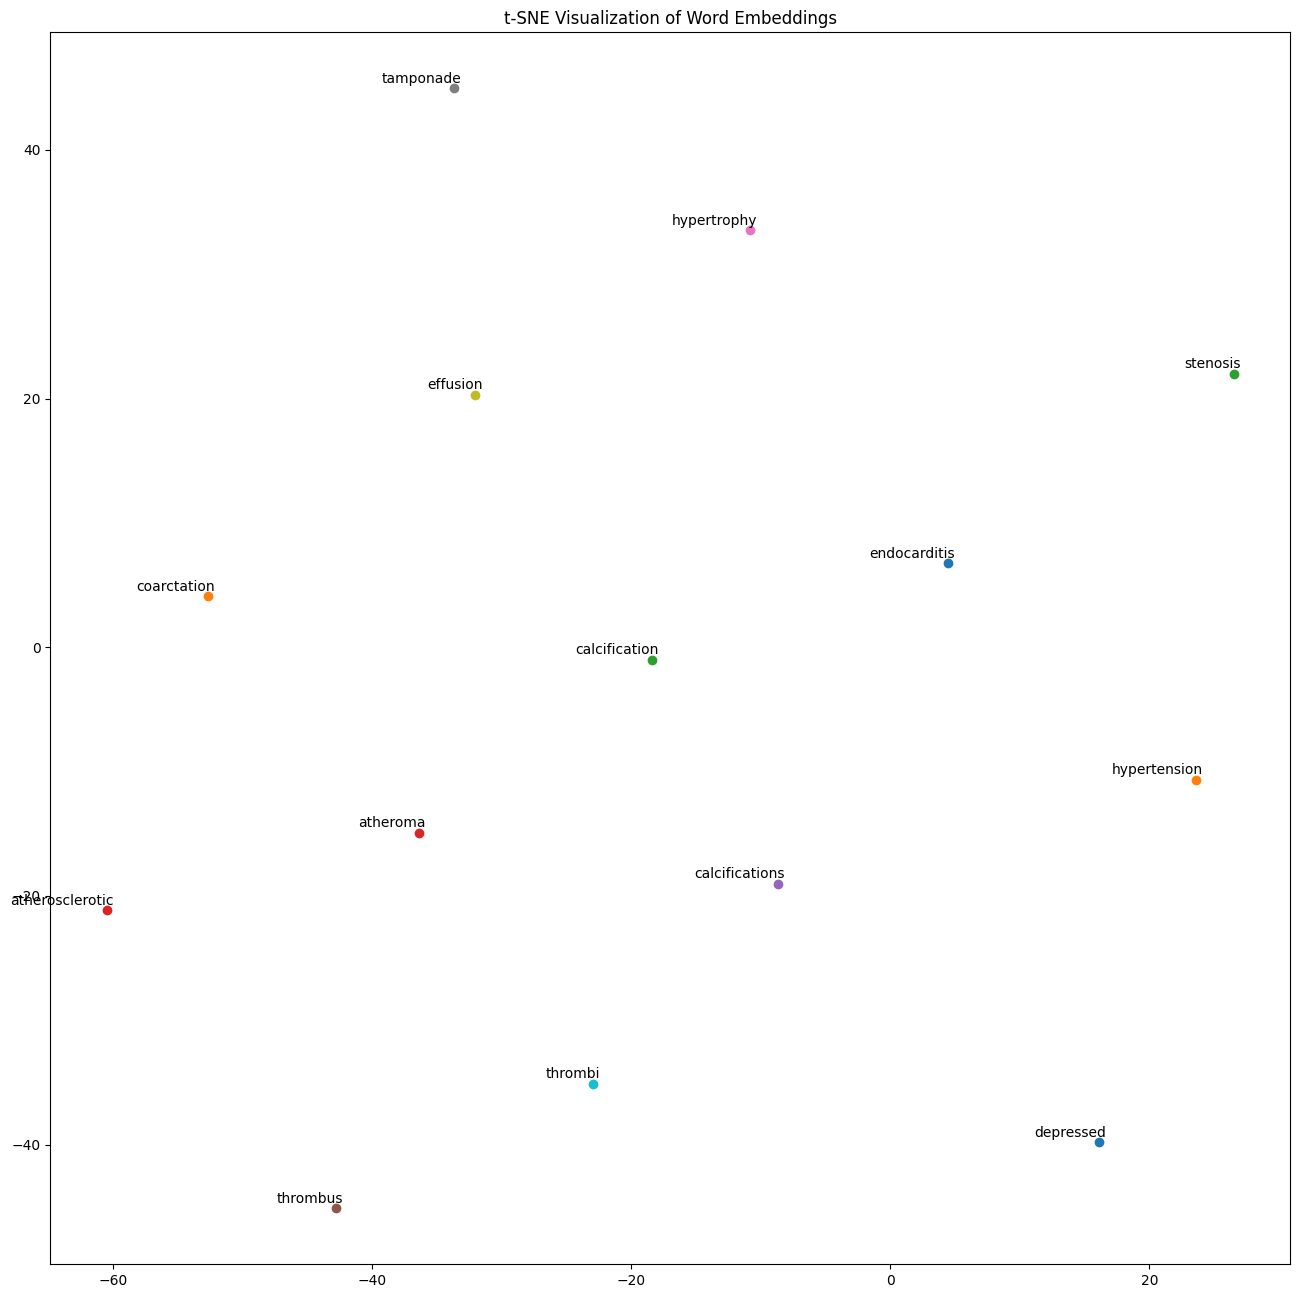

In [24]:
tsne_plot(pretrained_model,new_corpus_in_pretrained_model)

## Clinical BERT analysis

In [25]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import re
def clean_text(text):
    # Tokenize the text into words
    words = text.split()
    # Remove special characters and convert to lowercase
    clean_words = [word.lower() for word in words if word.isalnum()]
    # Remove stopwords
    stop_words = set(stopwords.words("english"))
    filtered_words = [word for word in clean_words if word not in stop_words]
    # Remove words with less than 4 characters and numbers. This is done in order to reduce noisy data and numbers dont contribute much in any NLP applications
    filtered_words = [word for word in filtered_words if len(word) >= 4 and not word.isdigit()]
    # Remove duplicate words
    cleaned_text = " ".join(dict.fromkeys(filtered_words)) # This is useful while plotting t-SNE plots
    return cleaned_text

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/balajisethuraman/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/balajisethuraman/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/balajisethuraman/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


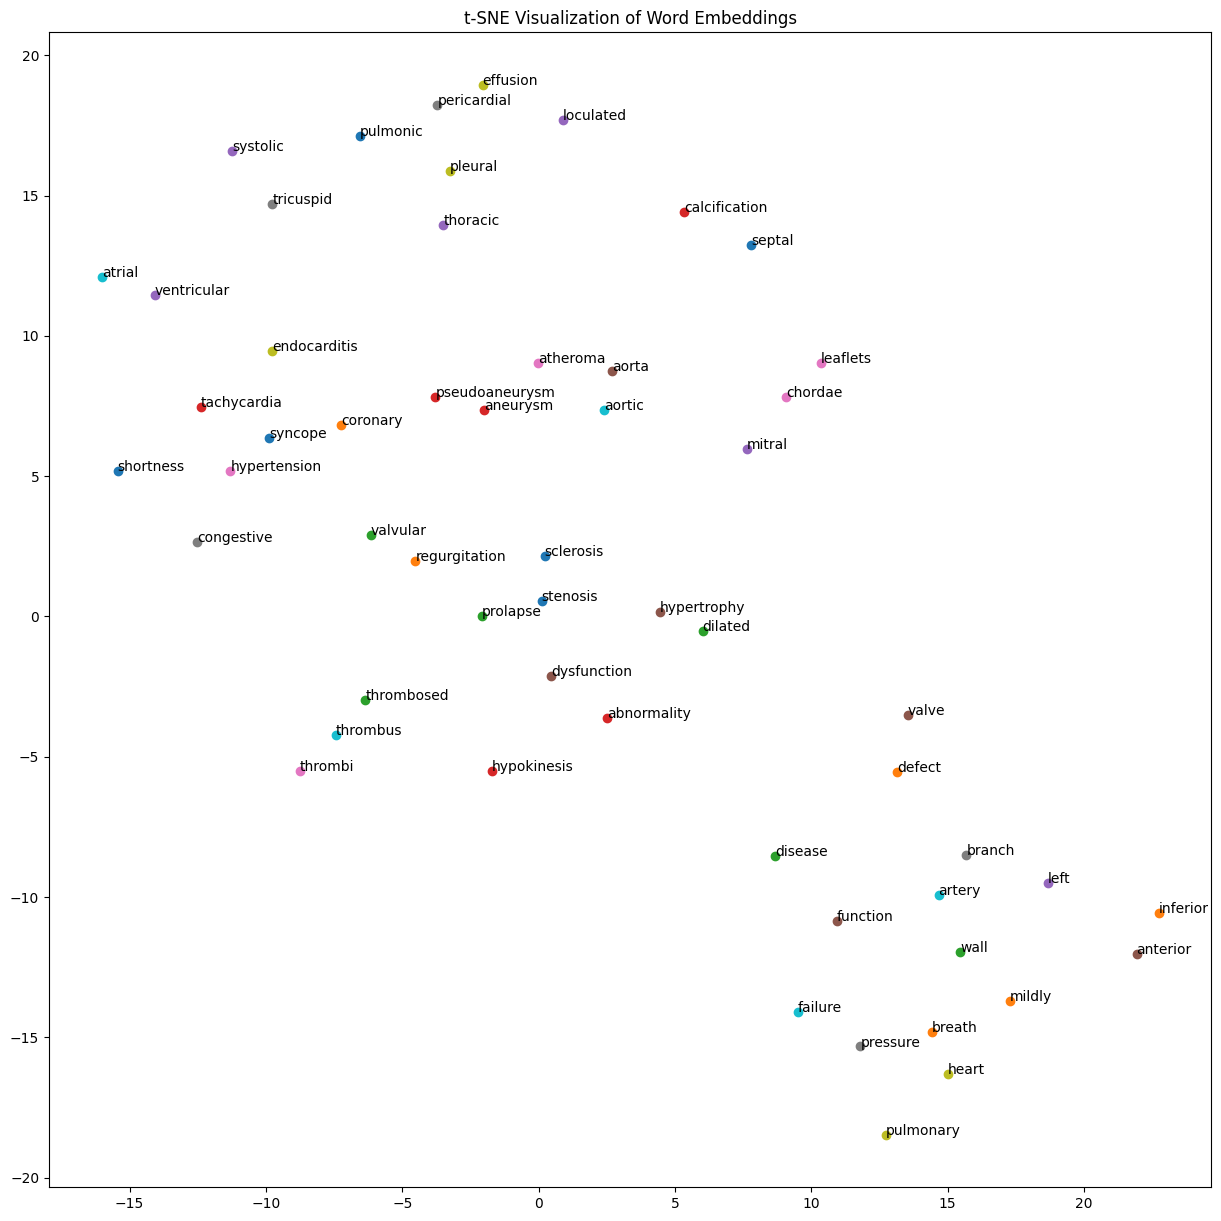

In [27]:
# Visualization of all notes using ClinicalBert
import numpy as np
from sklearn.manifold import TSNE
import string
import matplotlib.pyplot as plt
from transformers import AutoModel, AutoTokenizer
import torch


corpus = []
for index, text in enumerate(df['TEXT']):  # Iterate over the 'TEXT' column
    if index >= 20:  # Stop after 100 iterations
        break
    str_tokens = []
    tokens = nlp(text).ents  # Process each text using spaCy
    for token in tokens:
        str_tokens.append(token.text)  # Extract entity text
    corpus.append(str_tokens)  # Add to the corpus
    #print(f"Index: {index}, Text: {text}")

# Initialize an empty list to store the combined words
notes_combined = []
# Iterate through the sublists and combine the words
for sublist in corpus:
    notes_combined.extend(sublist)

#print(notes_combined)

# these notes contains all tokens that are extracted from the original notes using SciSpacy
notes_combined = ' '.join(notes_combined)
notes_combined

#print(notes_combined)

#remove newline from text
notes_combined = notes_combined.replace("\n", " ")

#print("Cleaned text:",notes_combined)


# Load the BERT model and tokenizer
clinical_model = AutoModel.from_pretrained("emilyalsentzer/Bio_ClinicalBERT")
clinical_tokenizer = AutoTokenizer.from_pretrained("emilyalsentzer/Bio_ClinicalBERT")
clinical_model.eval()

input_text = clean_text(notes_combined)

# Tokenize the input text using the BERT tokenizer
input_tokens = input_text.split()

#print("Input token:",input_tokens)

# Initialize an empty list to store word embeddings
word_embs = []
for token in input_tokens:
    # Check if the token is a valid word
    if token not in string.punctuation:
        # Encode the token using the BERT model
        inputs = clinical_tokenizer(token, return_tensors="pt")
        with torch.no_grad():
            outputs = clinical_model(**inputs)
        token_emb = outputs.last_hidden_state.mean(dim=1).squeeze().numpy()
        word_embs.append(token_emb)

# Perform t-SNE dimensionality reduction
tsne_model = TSNE(n_components=2, perplexity=10, random_state=42)
word_embs_2d = tsne_model.fit_transform(np.array(word_embs))

# Create a scatter plot of the word embeddings in 2D space
plt.figure(figsize=(15, 15))
for i in range(len(word_embs_2d)):
    plt.scatter(word_embs_2d[i, 0], word_embs_2d[i, 1])
    plt.annotate(input_tokens[i], (word_embs_2d[i, 0], word_embs_2d[i, 1]))

plt.title("t-SNE Visualization of Word Embeddings")
plt.show()